In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import seaborn as sns
import shap

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

In [33]:
feats = ['full_sq',
  'num_room',
  'cafe_count_5000_price_2500',
  'cafe_count_5000_price_high',
  'life_sq',
  'cafe_count_3000',
  'sport_count_3000',
  'cafe_count_2000',
  'floor',
  'state',
  'build_year',
  'kitch_sq',
  'cafe_count_3000_price_2500',
  'ttk_km',
  'material_nan',
  'max_floor',
  'office_sqm_5000',
  'cafe_count_2000_price_2500',
  'metro_min_avto',
  'public_healthcare_km',
  'product_type_Investment',
  'swim_pool_km',
  'railroad_km',
  'green_zone_km',
  'kindergarten_km',
  'metro_km_avto',
  'additional_education_km',
  'nuclear_reactor_km',
  'cafe_count_3000_price_1500',
  'product_type_OwnerOccupier',
  'detention_facility_km',
  'prom_part_1000',
  'metro_min_walk',
  'church_count_5000',
  'cafe_count_1500_price_500',
  'preschool_km',
  'cafe_count_1500',
  'cafe_count_2000_price_1000',
  'cafe_count_5000_price_4000',
  'cafe_count_1000',
  'fitness_km',
  'industrial_km',
  'oil_chemistry_km',
  'zd_vokzaly_avto_km',
  'green_part_5000',
  'cafe_count_5000',
  'prom_part_3000',
  'workplaces_km',
  'public_transport_station_km',
  'big_road1_km',
  'sport_objects_raion',
  'theater_km',
  'green_part_500',
  'radiation_km',
  'ts_km']

# Hyper Parameter Tuning

In [34]:
train_path = 'processed/processed_train_2.csv'

train_df = pd.read_csv(train_path)
y = train_df['price_doc']
# X = train_df.drop(['price_doc'], axis=1)
X = train_df[feats]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "early_stopping_rounds": 20,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0, 1),
        "bagging_freq": 1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2023-11-01 10:43:56,928] A new study created in memory with name: no-name-d08896e0-8fd1-4aef-a5d9-a46868046992
[I 2023-11-01 10:43:57,439] Trial 0 finished with value: 3690184.952174501 and parameters: {'n_estimators': 337, 'lambda_l2': 9.057440722089158, 'bagging_fraction': 0.3590074482650998, 'num_leaves': 367, 'feature_fraction': 0.7963840835041269, 'max_depth': 2, 'learning_rate': 0.002400829146687316, 'subsample': 0.512207194484435, 'colsample_bytree': 0.8033182495569603, 'min_data_in_leaf': 89}. Best is trial 0 with value: 3690184.952174501.
[I 2023-11-01 10:43:57,998] Trial 1 finished with value: 2579255.562627123 and parameters: {'n_estimators': 137, 'lambda_l2': 5.339055177314425, 'bagging_fraction': 0.4204958523966804, 'num_leaves': 1005, 'feature_fraction': 0.7737513293308103, 'max_depth': 7, 'learning_rate': 0.03839215345346587, 'subsample': 0.33027527899127274, 'colsample_bytree': 0.14983028862266784, 'min_data_in_leaf': 48}. Best is trial 1 with value: 2579255.56262712

In [35]:
best_params = study.best_params
best_params["objective"] = "regression"
best_params["metric"] = "rmse"
best_params["verbosity"] = -1
best_params

{'n_estimators': 258,
 'lambda_l2': 1.2171702783659422,
 'bagging_fraction': 0.8635637665797425,
 'num_leaves': 16,
 'feature_fraction': 0.9011565423125911,
 'max_depth': 10,
 'learning_rate': 0.050356741003664086,
 'subsample': 0.26032310570561995,
 'colsample_bytree': 0.3500081747230171,
 'min_data_in_leaf': 59,
 'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1}

# Finding Feat Importance

In [5]:
from lgbm_utils import cal_mean_errors
seed = 10

In [6]:
train_df = pd.read_csv('processed/train.csv')

In [7]:
model = lgb.LGBMRegressor(**best_params)
models = [model]

In [8]:
rmsles, most_important_features = cal_mean_errors(train_df, models, seed=seed)

0it [00:00, ?it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

[2547113.88454625]


col_name  feature_importance_vals
0                       full_sq             1.380120e+06
5                      num_room             2.945126e+05
257  cafe_count_5000_price_2500             2.818032e+05
259  cafe_count_5000_price_high             1.676903e+05
1                       life_sq             1.654418e+05
226             cafe_count_3000             1.500699e+05
241            sport_count_3000             1.367357e+05
203             cafe_count_2000             1.313192e+05
2                         floor             1.163684e+05
7                         state             1.062836e+05

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


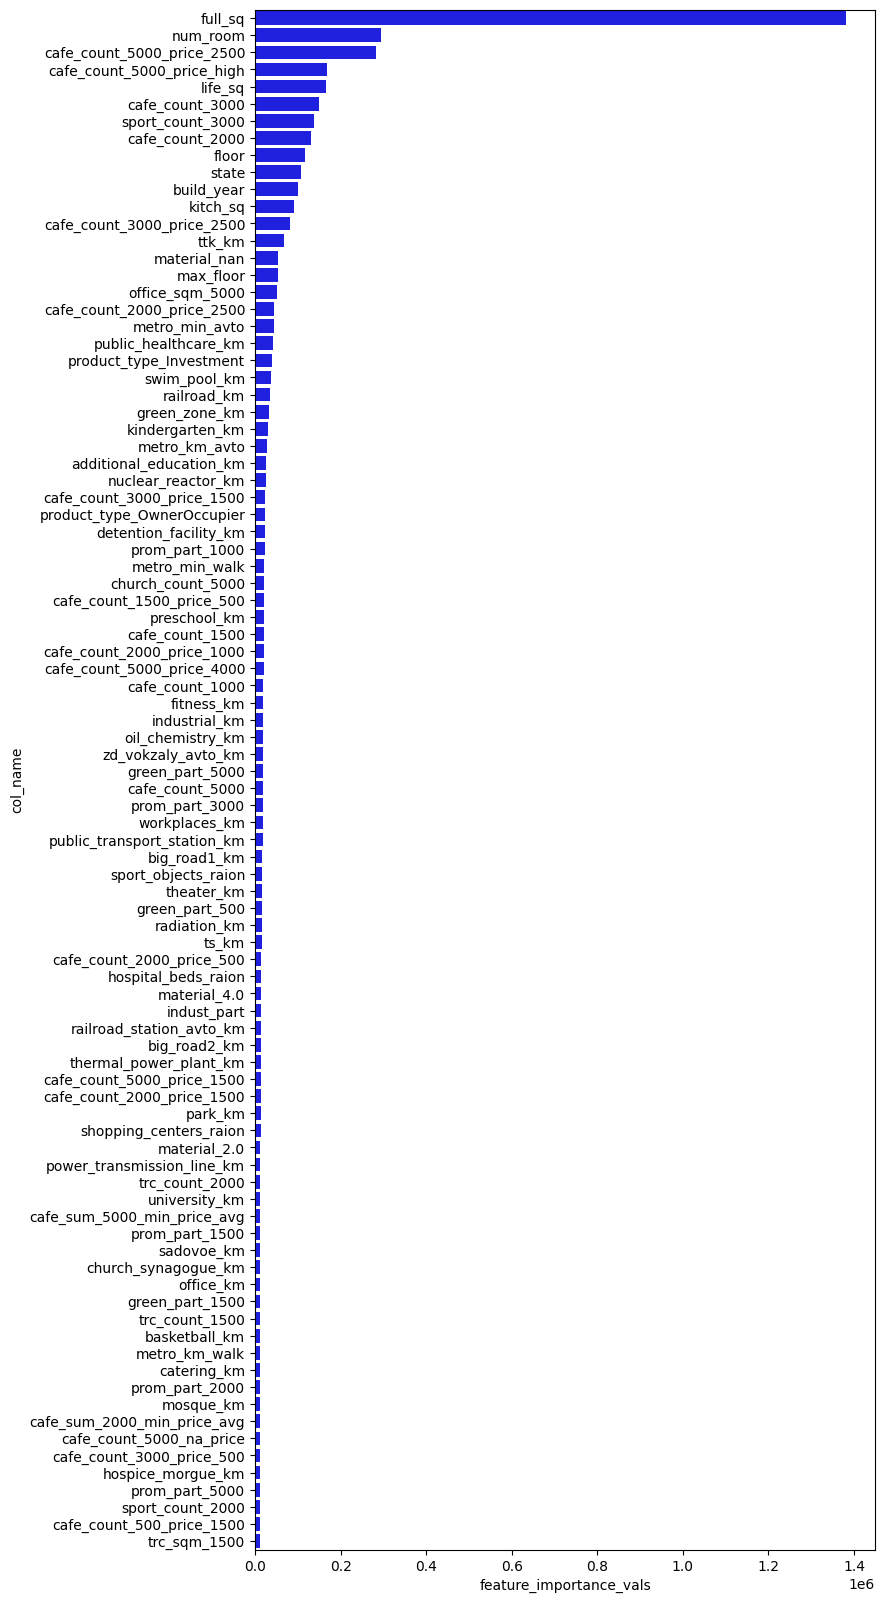

In [9]:
rmsles = np.array(rmsles)
print(rmsles)

for features in most_important_features:
    display(features.head(10))

limit = 90
for feats in most_important_features:
    plt.figure(figsize=(8, 20))
    sns.barplot(x="feature_importance_vals", y="col_name", data=feats.iloc[:limit],
            color="b")

# Choosing Top K features

In [10]:
from tqdm import tqdm

In [11]:
most_important_features_ = most_important_features[0]

In [13]:
step = 5
limit = 101
start = 10
features = most_important_features_.values[:, 0]
# features = most_important_features.values[:, 0]
# train_df = pd.read_csv(data_set_path)
rmsles = {}
for i in tqdm(range(start, limit, step), desc="Num Features"):
    print(f"Training for {i} features")

    model = lgb.LGBMRegressor(**best_params)
    
    # Train
    rmsles_, _ = cal_mean_errors(train_df, [model], features[:i], seed=seed)
    rmsles[i] = rmsles_

Num Features:   0%|          | 0/19 [00:00<?, ?it/s]

Training for 10 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 15 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 20 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 25 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 30 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 35 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 40 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 45 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 50 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 55 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 60 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 65 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 70 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 75 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 80 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 85 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 90 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 95 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 100 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Text(0, 0.5, 'RMSE')

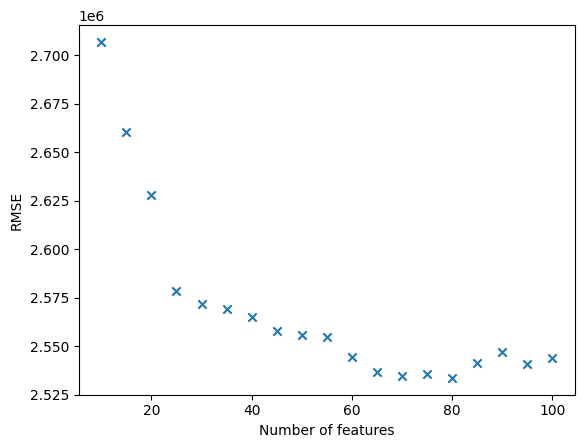

In [14]:
plt.scatter(rmsles.keys(), rmsles.values(), marker='x')
plt.xlabel('Number of features')
plt.ylabel('RMSE')

In [15]:
ordered_feats = sorted(rmsles.keys(), key=rmsles.get)
ordered_feats

[80, 70, 75, 65, 95, 85, 100, 60, 90, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10]

In [31]:
# Median
feats_to_use = most_important_features_[:ordered_feats[len(ordered_feats)//2]].values[:, 0].tolist()
len(feats_to_use), feats_to_use

(55,
 ['full_sq',
  'num_room',
  'cafe_count_5000_price_2500',
  'cafe_count_5000_price_high',
  'life_sq',
  'cafe_count_3000',
  'sport_count_3000',
  'cafe_count_2000',
  'floor',
  'state',
  'build_year',
  'kitch_sq',
  'cafe_count_3000_price_2500',
  'ttk_km',
  'material_nan',
  'max_floor',
  'office_sqm_5000',
  'cafe_count_2000_price_2500',
  'metro_min_avto',
  'public_healthcare_km',
  'product_type_Investment',
  'swim_pool_km',
  'railroad_km',
  'green_zone_km',
  'kindergarten_km',
  'metro_km_avto',
  'additional_education_km',
  'nuclear_reactor_km',
  'cafe_count_3000_price_1500',
  'product_type_OwnerOccupier',
  'detention_facility_km',
  'prom_part_1000',
  'metro_min_walk',
  'church_count_5000',
  'cafe_count_1500_price_500',
  'preschool_km',
  'cafe_count_1500',
  'cafe_count_2000_price_1000',
  'cafe_count_5000_price_4000',
  'cafe_count_1000',
  'fitness_km',
  'industrial_km',
  'oil_chemistry_km',
  'zd_vokzaly_avto_km',
  'green_part_5000',
  'cafe_coun

# Predicting

In [43]:
from sklearn.model_selection import KFold

def train(X, y, evalset=None):    
    model = lgb.LGBMRegressor(**best_params)
    if not evalset:
        model.fit(X, y)
    else:
        model.fit(X, y, eval_set=evalset)

    return model

def find_best_model(processed_df):
    # Return best model from kfolds
    best_model = None
    min_loss = float('inf')
    to_return = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(cv.split(processed_df)):
        X_train = processed_df.iloc[train_idx]
        y_train = X_train["price_doc"]
        X_train.drop(["price_doc"], axis=1, inplace=True)

        X_val = processed_df.iloc[test_idx]
        y_val = X_val["price_doc"]
        X_val.drop(["price_doc"], axis=1, inplace=True)

        evalset = [(X_val, y_val)]
        model = train(X_train, y_train, evalset)

        pred = model.predict(X_val)
        loss = mean_squared_error(y_val, pred, squared=False)
        
        to_return.append((model, loss))
    
    return to_return

In [44]:
processed_train = pd.read_csv('processed/processed_train_2.csv')

In [45]:
models = find_best_model(processed_train)#[feats_to_use+['price_doc']])
sorted_models = sorted(models, key=lambda x: x[1])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [46]:
for m in sorted_models:
    print(m[1])

2289153.348563405
2331886.407738174
2371018.8035864406
2388596.4981672647
2410171.4553546817
2535101.293825401
2603337.3648975454
2645744.5548109114
2654797.4200605284
3139024.7982589854


In [47]:
median_model = sorted_models[len(sorted_models)//2][0]

In [48]:
test_path = 'processed/processed_test_2.csv'
test_id_path = '../../Dataset/test.csv/test.csv'
output_path = 'output/'
processed_test = pd.read_csv(test_path)
test_id = pd.read_csv(test_id_path)

In [49]:
for i, (model, _) in enumerate(sorted_models):
    pred = model.predict(processed_test.drop(columns=['id']))#[feats_to_use])
    # Save predictions
    prediction_df = pd.DataFrame({
        'id': test_id['id'],
        'price_doc': pred
    })

    prediction_df.to_csv(f'{output_path}/lgbm_pred_{i}.csv', index=False)